<a href="https://colab.research.google.com/github/Fayjul/Machine-Learning/blob/master/ML_project_brain_tumar_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

In [ ]:
data = keras.utils.image_dataset_from_directory("/content/drive/MyDrive/ML_data/brain_tumor_dataset")

Found 253 files belonging to 2 classes.


In [ ]:
batch = data.as_numpy_iterator().next()


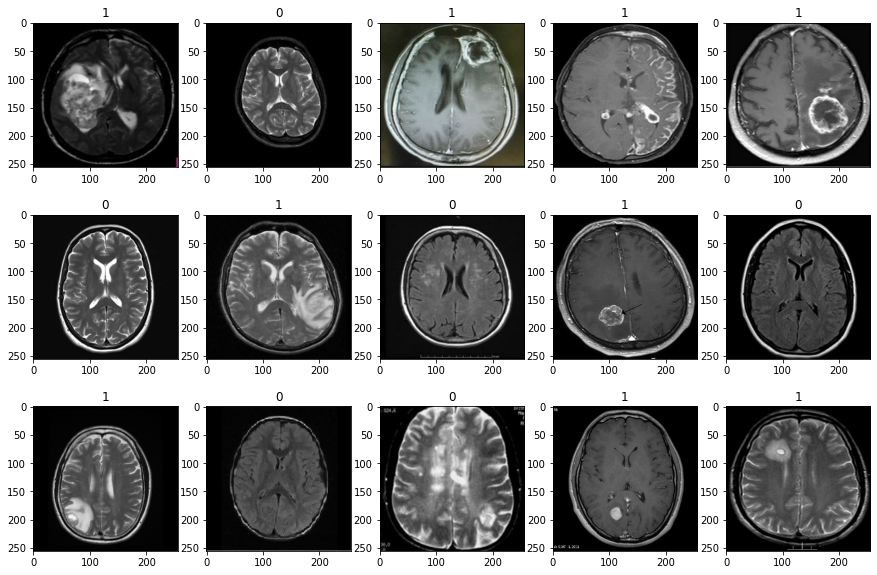

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
batch = data.as_numpy_iterator().next()

In [ ]:
print("Minimum value of the scaled data:", batch[0].min())
print("Maximum value of the scaled data:", batch[0].max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [ ]:
print("There are", len(data), "batches in our data")

There are 8 batches in our data


In [ ]:
train_size = int(len(data)*0.6)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.2)+1

In [ ]:
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)

print("Sum of Train, Validation and Test sizes is equal to:", train_size + val_size + test_size)

Train Size: 4
Validation Size: 2
Test Size: 2
Sum of Train, Validation and Test sizes is equal to: 8


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
batch = data.as_numpy_iterator().next()

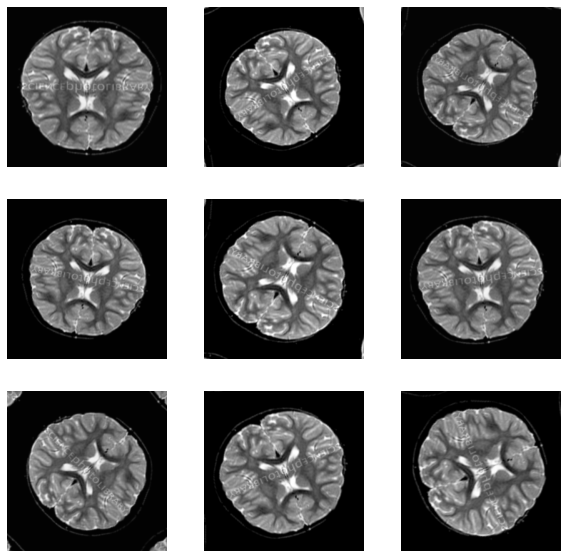

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(256,256,3)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomRotation(0.2)
])

image = batch[0]


plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")


In [ ]:
model = Sequential([
    data_augmentation,
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      25632     
                                                      

In [ ]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15


4/4 [==============================] - 44s 11s/step - loss: 0.7207 - accuracy: 0.6875 - val_loss: 0.6659 - val_accuracy: 0.7656
Epoch 2/15
4/4 [==============================] - 33s 8s/step - loss: 0.6366 - accuracy: 0.6250 - val_loss: 0.6903 - val_accuracy: 0.5469
Epoch 3/15
4/4 [==============================] - 32s 8s/step - loss: 0.6169 - accuracy: 0.6484 - val_loss: 0.6282 - val_accuracy: 0.7344
Epoch 4/15
4/4 [==============================] - 32s 8s/step - loss: 0.6287 - accuracy: 0.6719 - val_loss: 0.5730 - val_accuracy: 0.7500
Epoch 5/15
4/4 [==============================] - 32s 8s/step - loss: 0.5584 - accuracy: 0.6953 - val_loss: 0.5166 - val_accuracy: 0.8125
Epoch 6/15
4/4 [==============================] - 33s 9s/step - loss: 0.6017 - accuracy: 0.7031 - val_loss: 0.5321 - val_accuracy: 0.7344
Epoch 7/15
4/4 [==============================] - 31s 8s/step - loss: 0.4995 - accuracy: 0.7734 - val_loss: 0.5587 - val_accuracy: 0.8281
Epoch 8/15
4/4 [============================

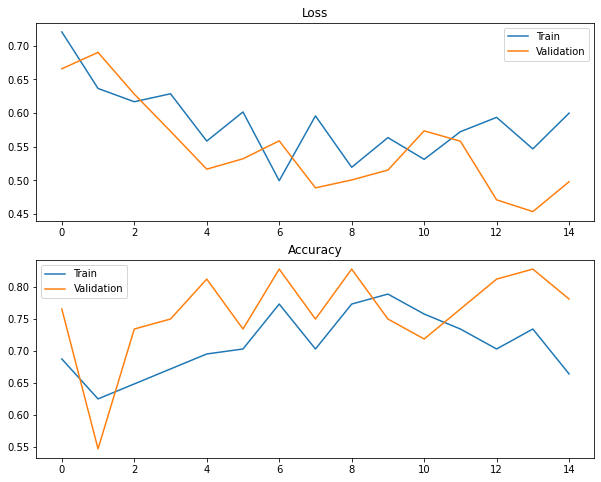

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history.history["loss"], label="Train")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train")
ax[1].plot(history.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()

In [ ]:
bin_acc = BinaryAccuracy()
recall = Recall()
precision = Precision()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

print("Accuracy:", bin_acc.result().numpy(), "\nRecall:", recall.result().numpy(), "\nPrecision:", precision.result().numpy())

1/1 [==============================] - 1s 1s/step
Accuracy: 0.8360656 
Recall: 0.8947368 
Precision: 0.85


In [ ]:
test_data = test.as_numpy_iterator().next()

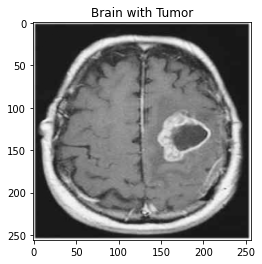

In [ ]:
img, label = test_data[0][15], test_data[1][15]
plt.imshow(img)
if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()

In [ ]:
y_pred = model.predict(np.expand_dims(img, 0))
print(y_pred)
if y_pred < 0.5:
    print("No tumor detected")
else:
    print("Tumor detected")

1/1 [==============================] - 0s 132ms/step
[[0.8482052]]
Tumor detected


In [ ]:
print(img)

[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.9980397  0.9980397  0.9980397 ]
  ...
  [0.9881442  0.9881442  0.9881442 ]
  [0.9745408  0.9745408  0.9745408 ]
  [0.97774345 0.97774345 0.97774345]]

 [[0.99911785 0.99911785 0.99911785]
  [0.97695243 0.97695243 0.97695243]
  [0.9078204  0.9078204  0.9078204 ]
  ...
  [0.88737947 0.88737947 0.88737947]
  [0.9654315  0.9654315  0.9654315 ]
  [0.98229635 0.98229635 0.98229635]]

 [[0.9929994  0.9929994  0.9929994 ]
  [0.88660926 0.88660926 0.88660926]
  [0.64619297 0.64619297 0.64619297]
  ...
  [0.6481826  0.6481826  0.6481826 ]
  [0.9250823  0.9250823  0.9250823 ]
  [0.99901986 0.99901986 0.99901986]]

 ...

 [[0.9929994  0.9929994  0.9929994 ]
  [0.88660926 0.88660926 0.88660926]
  [0.64619297 0.64619297 0.64619297]
  ...
  [0.6496302  0.6496302  0.6496302 ]
  [0.93145525 0.93145525 0.93145525]
  [0.9999849  0.9999849  0.9999849 ]]

 [[0.99911785 0.99911785 0.99911785]
  [0.97695243 0.97695243 0.97695243]


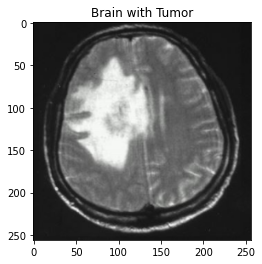

In [ ]:
img, label = batch[0][19], batch[1][19]
plt.imshow(img)
if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()

In [ ]:
# This cell has error
import torch

from torchvision import transforms

from PIL import Image

convert_tensor = transforms.ToTensor()
from google.colab import files

img = Image.open("/content/drive/MyDrive/ML_data/brain_tumor_dataset/no/3 no.jpg")

img2 = convert_tensor(img)
y_pred = model.predict(np.expand_dims(img2, 0))

UnimplementedError: ignored

In [ ]:
from google.colab import files


img = files.upload()
print(img)


Saving 1 no.jpeg to 1 no (2).jpeg
{'1 no.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x02\x00&\x00&\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x02v\x02v\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x01\x04\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x05\x06\x01\x04\x07\x08\t\xff\xc4\x00@\x10\x00\x02\x01\x03\x03\x02\x05\x03\x02\x05\x03\x03\x03\x02\x07\x01\x01\x02\x03\x00\x04\x11\x05\x12!\x061\x07\x13"AQ\x082a\x14q\x15#B\x81\xa1R\x91\xb1\x16$\xc13Cbr\xd1\x17%S\x92\xe1\xf0\xf1\x82\xff\xda\x00\x08\x01\x01\x00\x00?\x00\xf9UE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x14QE\x00\x1c\xe2\xb3\xb1\xb3\x8cb\x94bo\xdf\x1d\xe9K\n\xb7\x00\xe

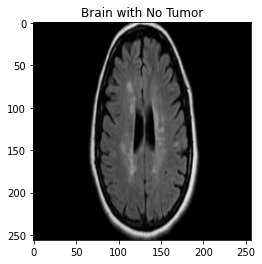

In [ ]:
img, label = test_data[0][0], test_data[1][0]
plt.imshow(img)
if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()

In [ ]:
y_pred = model.predict(np.expand_dims(img, 0))
print(y_pred)
if y_pred < 0.5:
    print("No tumor detected")
else:
    print("Tumor detected")

1/1 [==============================] - 0s 65ms/step
[[0.19412763]]
No tumor detected
